### OCR with Qwen3-Omni

In [1]:
import os
os.environ['VLLM_USE_V1'] = '0'
os.environ['VLLM_WORKER_MULTIPROC_METHOD'] = 'spawn'
os.environ["VLLM_LOGGING_LEVEL"] = "ERROR"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import torch
import warnings
import numpy as np

warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

from zen_omni_utils import process_mm_info
from transformers import Qwen3OmniMoeProcessor

def _load_model_processor():
    if USE_TRANSFORMERS:
        from transformers import Qwen3OmniMoeForConditionalGeneration
        if TRANSFORMERS_USE_FLASH_ATTN2:
            model = Qwen3OmniMoeForConditionalGeneration.from_pretrained(MODEL_PATH,
                                                                         dtype='auto',
                                                                         attn_implementation='flash_attention_2',
                                                                         device_map="auto")
        else:
            model = Qwen3OmniMoeForConditionalGeneration.from_pretrained(MODEL_PATH, device_map="auto", dtype='auto')
    else:
        from vllm import LLM
        model = LLM(
            model=MODEL_PATH, trust_remote_code=True, gpu_memory_utilization=0.95,
            tensor_parallel_size=torch.cuda.device_count(),
            limit_mm_per_prompt={'image': 1, 'video': 3, 'audio': 3},
            max_num_seqs=1,
            max_model_len=32768,
            seed=1234,
        )

    processor = Qwen3OmniMoeProcessor.from_pretrained(MODEL_PATH)
    return model, processor

def run_model(model, processor, messages, return_audio, use_audio_in_video):
    if USE_TRANSFORMERS:
        text = processor.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)
        audios, images, videos = process_mm_info(messages, use_audio_in_video=use_audio_in_video)
        inputs = processor(text=text, audio=audios, images=images, videos=videos, return_tensors="pt", padding=True, use_audio_in_video=use_audio_in_video)
        inputs = inputs.to(model.device).to(model.dtype)
        text_ids, audio = model.generate(**inputs, 
                                            thinker_return_dict_in_generate=True,
                                            thinker_max_new_tokens=8192, 
                                            thinker_do_sample=False,
                                            speaker="Ethan", 
                                            use_audio_in_video=use_audio_in_video,
                                            return_audio=return_audio)
        response = processor.batch_decode(text_ids.sequences[:, inputs["input_ids"].shape[1] :], skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
        if audio is not None:
            audio = np.array(audio.reshape(-1).detach().cpu().numpy() * 32767).astype(np.int16)
        return response, audio
    else:
        from vllm import SamplingParams
        sampling_params = SamplingParams(temperature=1e-2, top_p=0.1, top_k=1, max_tokens=8192)
        text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        audios, images, videos = process_mm_info(messages, use_audio_in_video=use_audio_in_video)
        inputs = {'prompt': text, 'multi_modal_data': {}, "mm_processor_kwargs": {"use_audio_in_video": use_audio_in_video}}
        if images is not None: inputs['multi_modal_data']['image'] = images
        if videos is not None: inputs['multi_modal_data']['video'] = videos
        if audios is not None: inputs['multi_modal_data']['audio'] = audios
        outputs = model.generate(inputs, sampling_params=sampling_params)
        response = outputs[0].outputs[0].text
        return response, None
    

In [ ]:
import librosa
import audioread

from IPython.display import Video
from IPython.display import Image
from IPython.display import Audio

MODEL_PATH = "Qwen/Qwen3-Omni-30B-A3B-Instruct"
# MODEL_PATH = "Qwen/Qwen3-Omni-30B-A3B-Thinking"

USE_TRANSFORMERS = False
TRANSFORMERS_USE_FLASH_ATTN2 = True

model, processor = _load_model_processor()

USE_AUDIO_IN_VIDEO = True
RETURN_AUDIO = False

Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'interleaved', 'mrope_section'}
Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'interleaved', 'mrope_section'}
`torch_dtype` is deprecated! Use `dtype` instead!
2025-09-14 19:38:44,514	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
You are attempting to use Flash Attention 2 without specifying a torch dtype. This might lead to unexpected behaviour
Loading safetensors checkpoint shards:   0% Completed | 0/15 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:   7% Completed | 1/15 [00:00<00:09,  1.54it/s]
Loading safetensors checkpoint shards:  20% Completed | 3/15 [00:01<00:06,  1.81it/s]
Loading safetensors checkpoint shards:  27% Completed | 4/15 [00:02<00:08,  1.25it/s]
Loading safetensors checkpoint shards:  33% Completed | 5/15 [00:03<00:05,  1.74it/s]
Loading safetensors checkpoint shards:  40% Comp

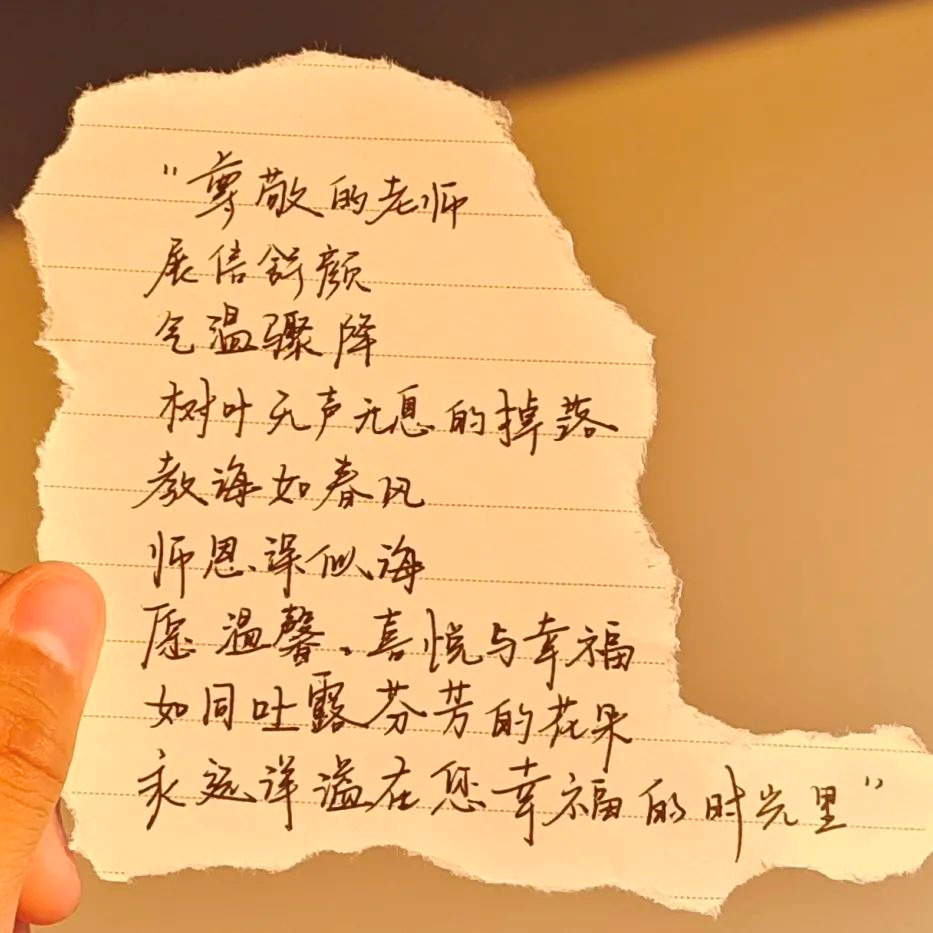

Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.85it/s, est. speed input: 1586.96 toks/s, output: 103.69 toks/s]

尊敬的老师
展信舒颜
气温骤降
树叶无声无息的掉落
教诲如春风
师恩深似海
愿温馨、喜悦与幸福
如同吐露芬芳的花朵
永远洋溢在您幸福的时光里


In [ ]:
image_path = "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen3-Omni/cookbook/ocr2.jpeg"

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image_path},
            {"type": "text", "text": "请提取图片中的文字。"},
        ]
    }
]

display(Image(image_path, width=640, height=360))

response, _ = run_model(model=model, messages=messages, processor=processor, return_audio=RETURN_AUDIO, use_audio_in_video=USE_AUDIO_IN_VIDEO)

print(response)

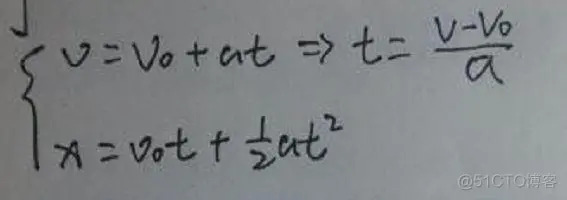

Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s, est. speed input: 163.51 toks/s, output: 109.88 toks/s]

$$\left\{ \begin{array} { l } { v = v _ { 0 } + a t \Rightarrow t = \frac { v - v _ { 0 } } { a } } \\ { x = v _ { 0 } t + \frac { 1 } { 2 } a t ^ { 2 } } \end{array} \right.$$


In [ ]:
image_path = "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen3-Omni/cookbook/ocr1.jpeg"

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image_path},
            {"type": "text", "text": "Extract the text from the image."},
        ]
    }
]

display(Image(image_path, width=640, height=360))

response, _ = run_model(model=model, messages=messages, processor=processor, return_audio=RETURN_AUDIO, use_audio_in_video=USE_AUDIO_IN_VIDEO)

print(response)